# Regression example with a neural network applied to efficiency tables

In [1]:
import pickle
import gzip
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer

In [10]:
with gzip.open("rec_hist_pt_25.pkl.gz") as f:
    rec = pickle.load(f)

with gzip.open("gen_hist_pt_25.pkl.gz") as f:
    gen = pickle.load(f)

rec = rec[:,:,:,sum,:]
gen = gen[:,:,:,sum,:]
# fix for divide by zero
gen.values()[gen.values() == 0] = 1
eff = rec.values() / gen.values()

X = []
y = []
for ieta, eta in enumerate(rec.axes[0].centers):
    for ipt, pt in enumerate(rec.axes[1].centers):
        for iphi, phi in enumerate(rec.axes[2].centers):
            for isp, sp in enumerate(rec.axes[3]):
                X.append((eta, pt, phi, isp))
                y.append(eff[ieta, ipt, iphi, isp])

X = np.array(X)
y = np.array(y)

In [15]:
mpl = MLPRegressor(hidden_layer_sizes=(2**8,)*5, alpha=0, tol=1e-7)
def fwd(x):
    r = x.copy()
    r[:, 1] = np.log(x[:, 1])
    return r

pT_trans = FunctionTransformer(func=fwd)
clf = make_pipeline(pT_trans, StandardScaler(), mpl)
clf.fit(X, y)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function fwd at 0x12f530680>)),
                ('standardscaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(alpha=0,
                              hidden_layer_sizes=(256, 256, 256, 256, 256),
                              tol=1e-07))])

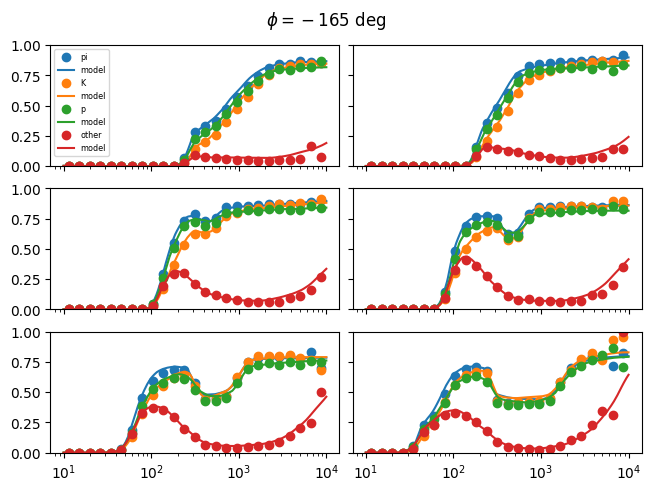

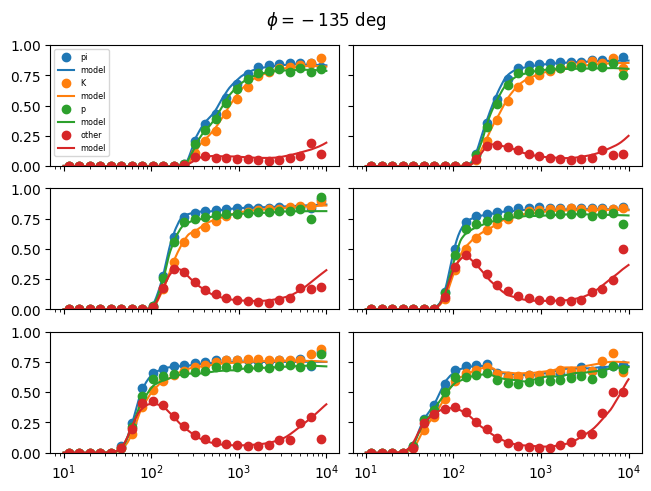

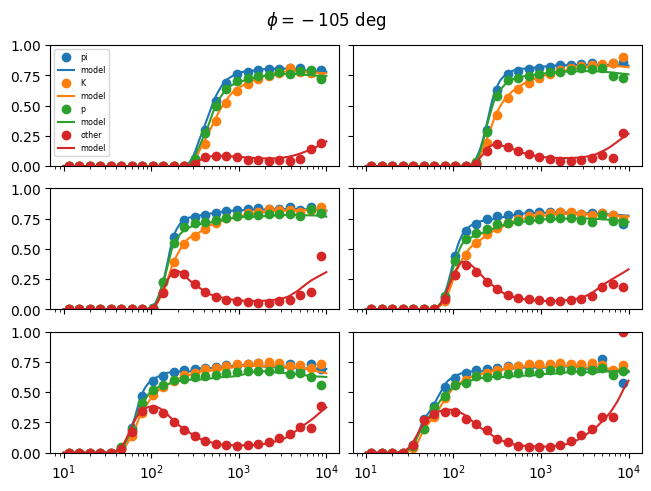

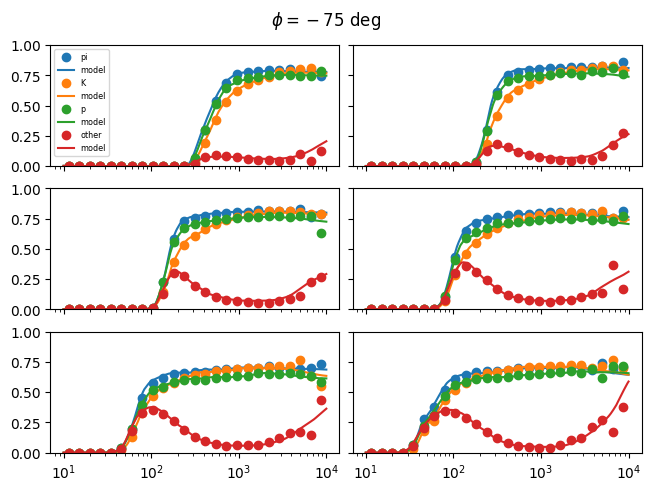

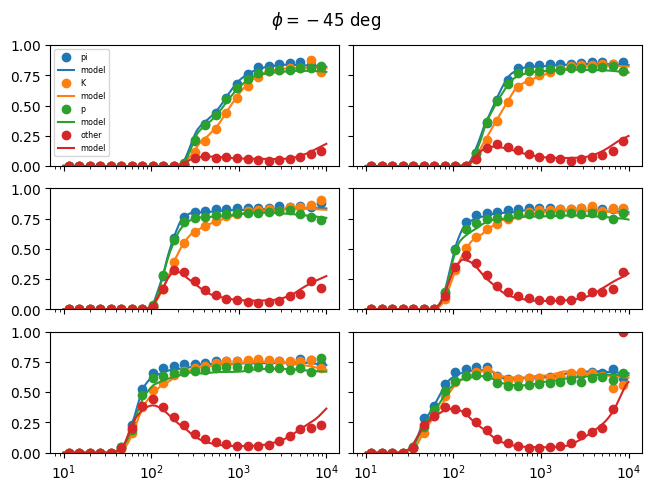

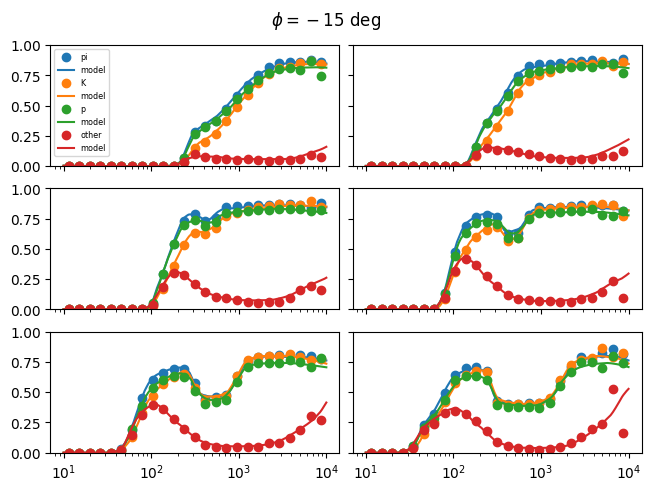

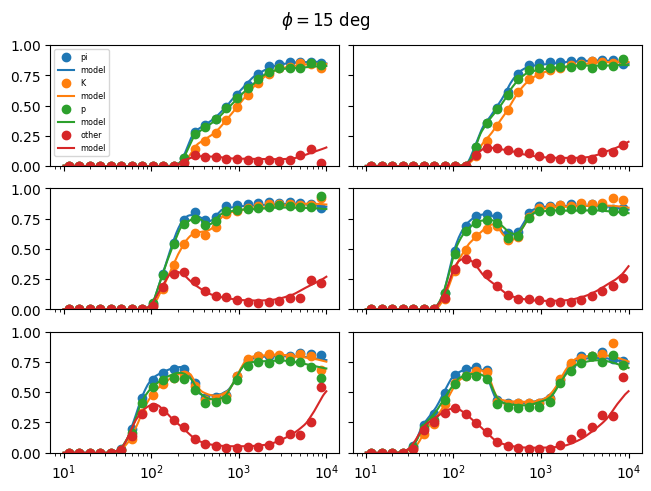

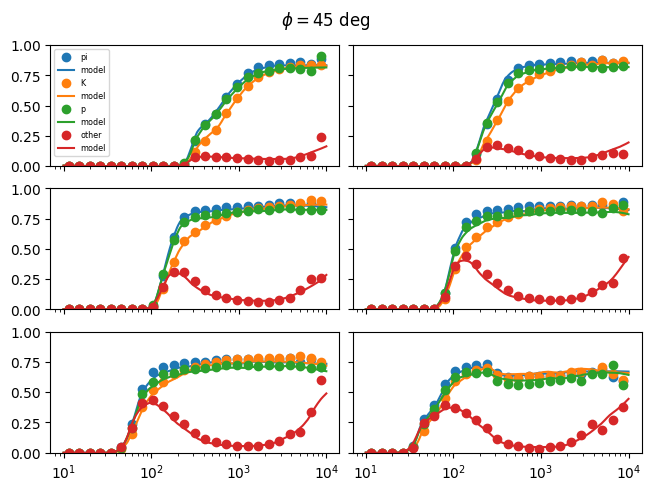

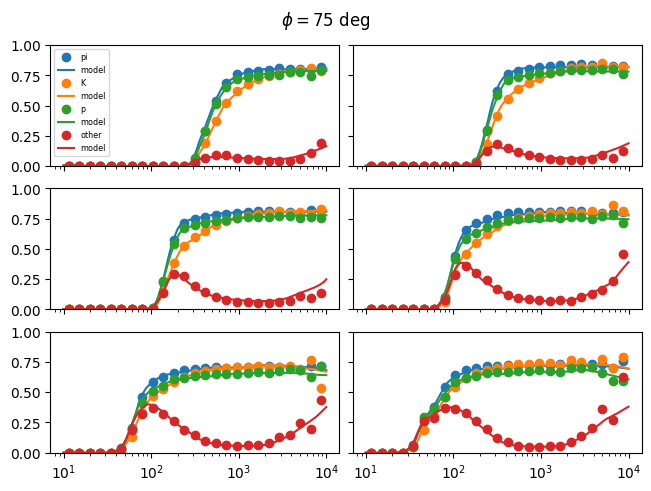

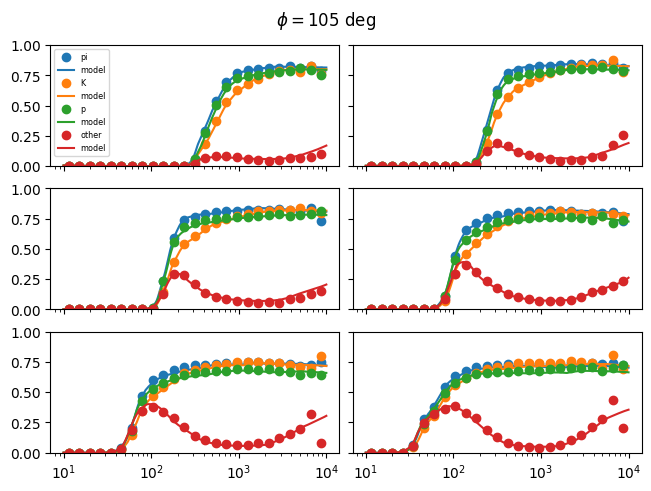

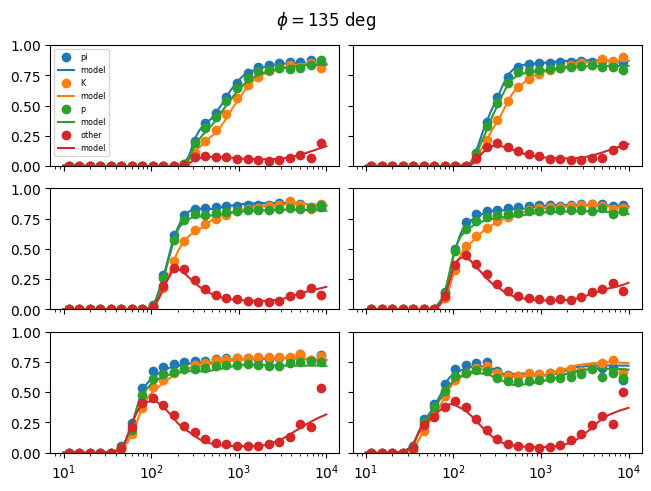

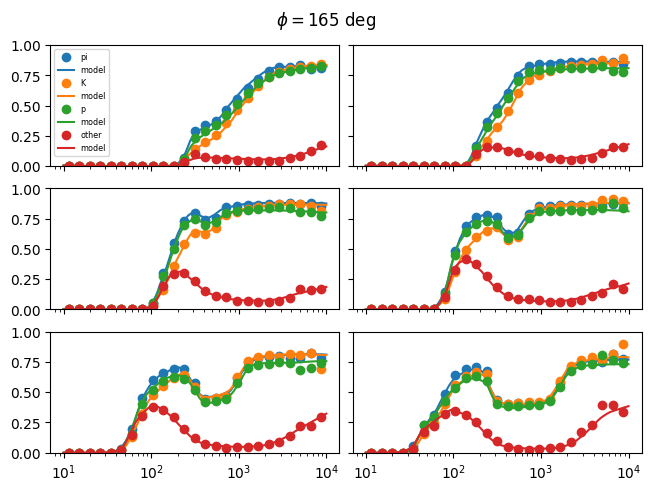

In [16]:
labels = ("pi", "K", "p", "other")
for phii in rec.axes[2].centers:
    fig, axes = plt.subplots(3, 2, sharex=True, sharey=True, layout="compressed")
    plt.suptitle(rf"$\phi = {np.degrees(phii):.0f}$ deg")
    for etai, axi in zip(rec.axes[0].centers, axes.flat):
        plt.sca(axi)
        for isp, label in enumerate(labels):
            ma = X[:, 0] == etai
            ma &= X[:, 2] == phii
            ma &= X[:, 3] == isp
            l, = plt.plot(X[ma, 1], y[ma], "o", label=f"{label}")

            mpt = np.geomspace(10, 1e4, 2000)
            Xp = np.empty((len(mpt), 4))
            Xp[:, 0] = etai
            Xp[:, 1] = mpt
            Xp[:, 2] = phii
            Xp[:, 3] = isp
            yp = clf.predict(Xp)
            plt.plot(Xp[:, 1], yp, label=f"model", color=l.get_color())

    plt.sca(axes[0,0])
    plt.semilogx()
    plt.ylim(0, 1)
    plt.legend(fontsize="xx-small");